### Постановка задачи

**Задача**  

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

* `course_project_train.csv` - обучающий датасет
* `course_project_test.csv` - тестовый датасет

**Целевая переменная**

* `Credit Default` - факт невыполнения кредитных обязательств

**Метрика качества**

* `F1-score` (sklearn.metrics.f1_score)

**Требования к решению**

* Целевая метрика F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать**

* Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу `{ФИО}_solution.ipynb`, пример `SShirkin_solution.ipynb`
* Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу `{ФИО}_predictions.csv`, пример `SShirkin_predictions.csv`
* Рекомендации для файла с кодом (ipynb)
* Файл должен содержать заголовки и комментарии (markdown)
* Повторяющиеся операции лучше оформлять в виде функций
* Не делать вывод большого количества строк таблиц (5-10 достаточно)
* По возможности добавлять графики, описывающие данные (около 3-5)
* Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
* Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
* Весь проект должен быть в одном скрипте (файл ipynb).
* Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.


**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Подключение библиотек и загрузка данных

In [1]:
# !pip install xgboost, lightgbm, catboost

In [46]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from catboost import CatBoostClassifier, CatBoostRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# rcParams['figure.figsize'] = 10, 8
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
TRAIN_DATASET_PATH='course_project_train.csv'
TEST_DATASET_PATH='course_project_test.csv'
PREPARED_TRAIN_DATASET_PATH='train_prepared.csv'
PREPARED_TEST_DATASET_PATH='test_prepared.csv'

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
* Credit Score - Кредитный балл

In [9]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обзор данных

**Обзор целевой переменной**

In [12]:
target_values = df_train['Credit Default'].value_counts()
target_values

0    5387
1    2113
Name: Credit Default, dtype: int64

Определим дисбаланс целевой переменной, далее будем использовать для финальной модели

In [13]:
balance = df_train['Credit Default'].value_counts()[0] / df_train['Credit Default'].value_counts()[1]
balance

2.549455750118315

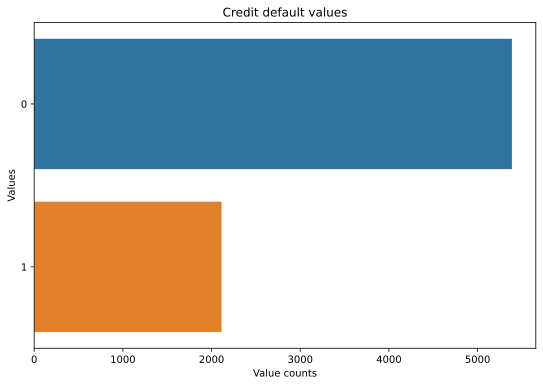

In [14]:
plt.figure(figsize=(9, 6))

sns.barplot(target_values.values, target_values.index, orient='h')
plt.title('Credit default values')
plt.xlabel('Value counts')
plt.ylabel('Values')
plt.show()

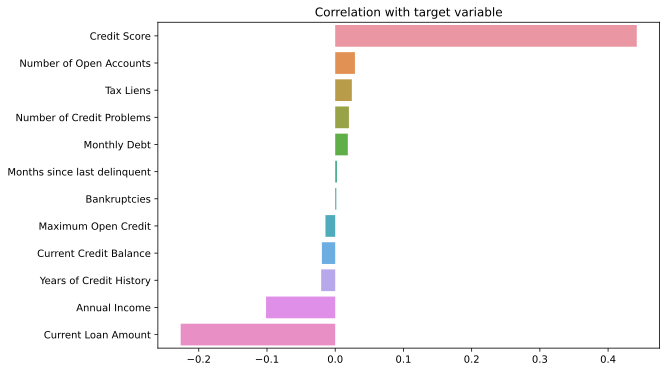

In [15]:
#Корелляция с базовыми признаками

TARGET = 'Credit Default'
FEATURES = df_train.columns.drop(TARGET).tolist()

corr_with_target = df_train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(9, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Целевая переменная коррелирует с Credit Score и Current Loan Amount

**Обзор количественных признаков**

In [17]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


* `Annual Income` - есть пропущенные значения / возможно, поле связано с Years in current job
* `Tax Liens` значения по большей части - нули. 
* `Number of Open Accounts` - есть выбросы (> 25) (Оставлю, как есть)
* `Years of Credit History` - есть очень большие значения, пока оставим
* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности, есть выбросы
* `Current Loan Amount` - есть выбросы
* `Current Credit Balance` 
* `Monthly Debt` - есть корелляция с доходом
* `Number of Credit Problems`  
? * `Months since last delinquent` - есть пропущенные значения. Скорее всего связано с целевой переменной  
? * `Bankruptcies` - есть немного пропусков
* `Credit Score` - есть много пропусков, корелляция с целевой

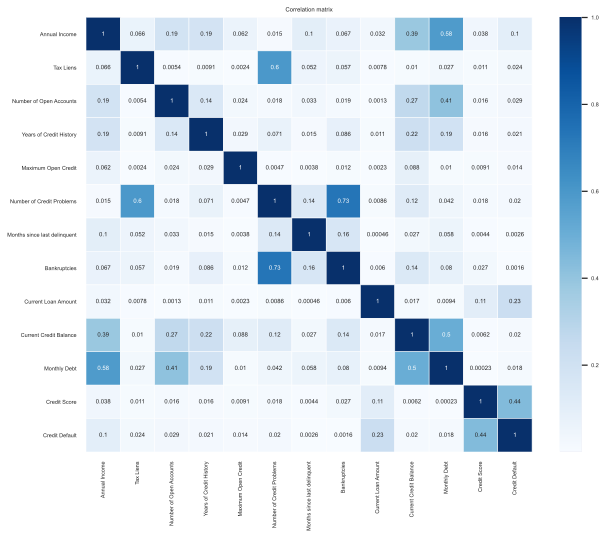

In [19]:
df_train.corr()
plt.figure(figsize=(10,8))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr().abs(), annot=True, linewidth=.5, cmap='Blues')
plt.title('Correlation matrix')
plt.show()

Наблюдается корреляция у следующих признаков: 
* `Number of Credit Problems` - `Bankruptcies` - 0,73
* `Number of Credit Problems` - `Tax Liens` - 0,6
* `Annual Income` - `Monthly Debt` - 0,58
* `Current Credit Balance` - `Monthly Debt` - 0,5
* `Credit Score` - `Credit Default` - 0,44
* `Number of Open Accounts` - `Monthly Debt` - 0,41
* `Annual Income` - `Current Credit Balance` - 0,39
* `Number of Open Accounts` - `Current Credit Balance` - 0,27
* `Years of Credit History` - `Current Credit Balance` - 0,22

In [20]:
df_train['Tax Liens'].value_counts().sort_values()

7.0       1
5.0       2
6.0       2
4.0       6
3.0      10
2.0      30
1.0      83
0.0    7366
Name: Tax Liens, dtype: int64

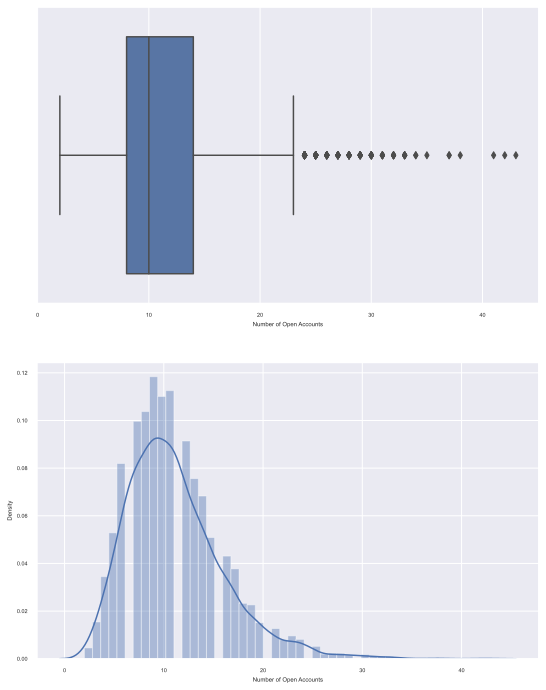

In [21]:
plt.figure(figsize=(9, 12))
plt.title('Number of Open Accounts distribution')

plt.subplot(211)
sns.boxplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')

plt.subplot(212)
sns.distplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')
plt.show()

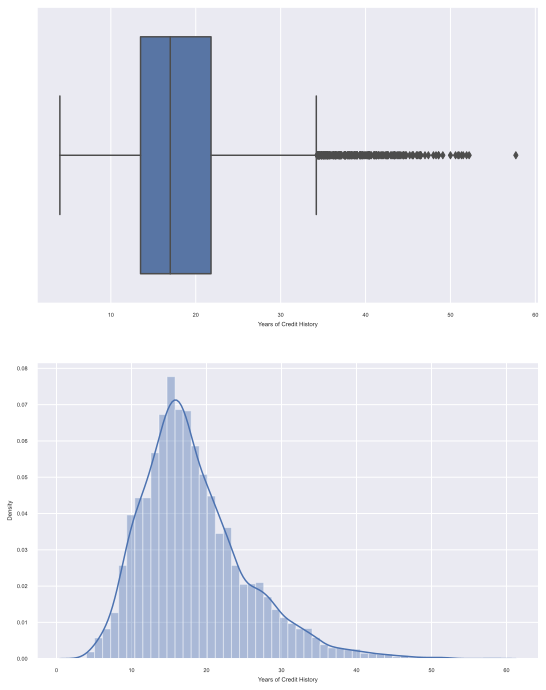

In [22]:
plt.figure(figsize=(9, 12))
plt.title('Number of Years of Credit History')

plt.subplot(211)
sns.boxplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')

plt.subplot(212)
sns.distplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')
plt.show()

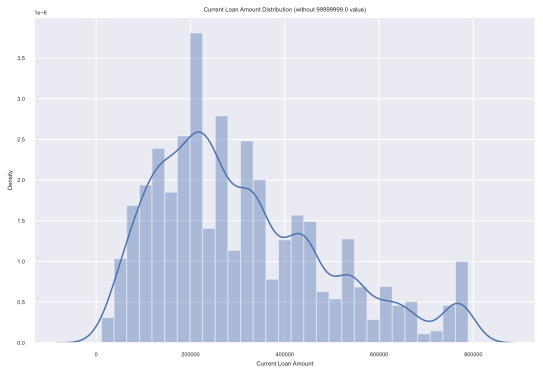

264616.0        1
186846.0        1
367334.0        1
290642.0        1
200640.0        1
             ... 
270226.0        5
216106.0        5
218064.0        6
89298.0         6
99999999.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64


In [23]:
plt.figure(figsize=(9, 6))
plt.title('Current Loan Amount Distribution (without 99999999.0 value)')
plt.xlabel('Current Loan Amount')
plt.xlabel('Density')
sns.distplot(df_train['Current Loan Amount'].loc[df_train['Current Loan Amount'] < 99999999.0])
plt.show()
print(df_train['Current Loan Amount'].value_counts().sort_values())

In [24]:
df_train.loc[df_train['Maximum Open Credit'] > 10000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,NaN,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,99999999.0,2315169.0,74991.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


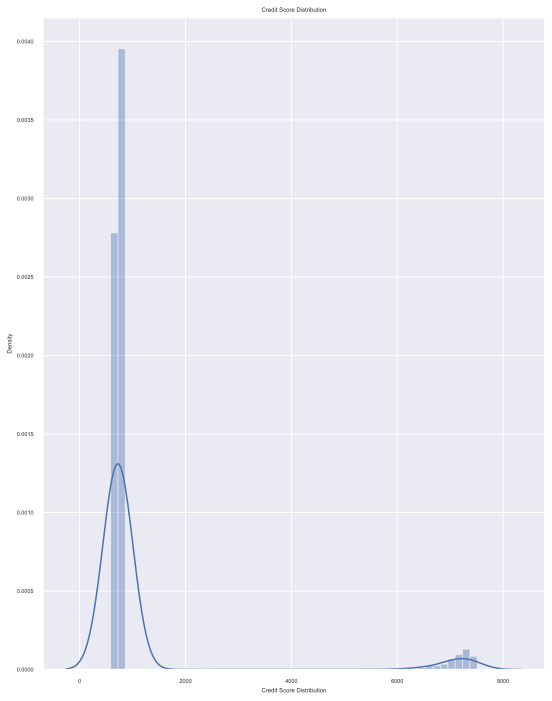

In [25]:
plt.figure(figsize=(9, 12))
plt.title('Credit Score Distribution')
sns.distplot(df_train['Credit Score'])
plt.xlabel('Credit Score Distribution')
plt.show()

Видно, что есть значения, которые находятся в другом интервале значений. Посмотрим на значения в разрезе целевой переменной.

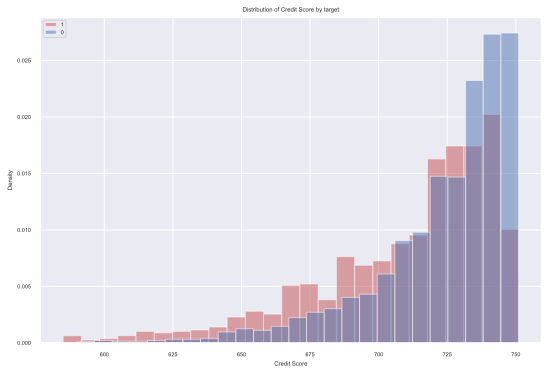

1184 1 values
4359 0 values


In [26]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] < 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] < 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print("%d 1 values\n%d 0 values" % 
      (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count(), 
                                   
       df_train.loc[(df_train['Credit Default'] == 0) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count()))
    


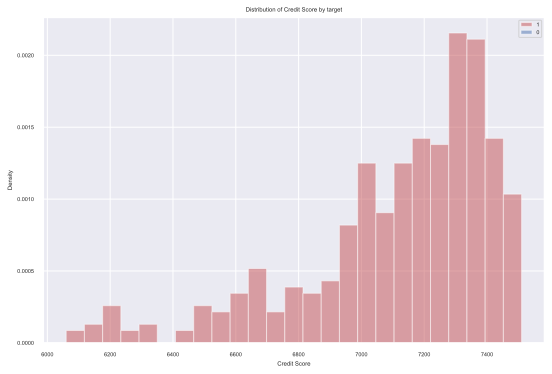

400 values


In [27]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] > 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] > 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] > 1000), 'Credit Score'].count(), 'values')


In [28]:
df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] < 1000), 'Credit Score'].count()

1184

**Проверка распределения вещественных признаков на трейне и тесте**

In [30]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [49]:
df_train['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [60]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                    'Bankruptcies']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems',
                   'Bankruptcies', 'Purpose', 'Term']


Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


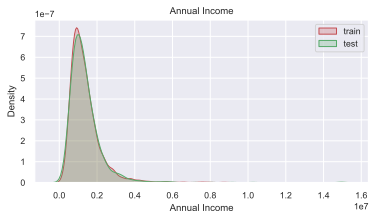

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


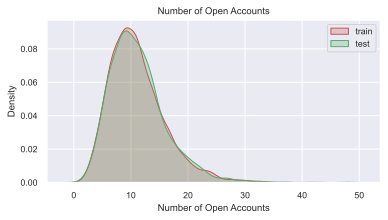

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


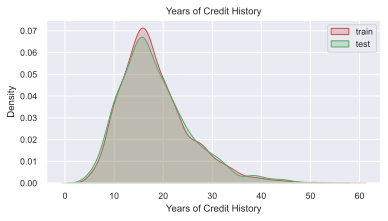

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


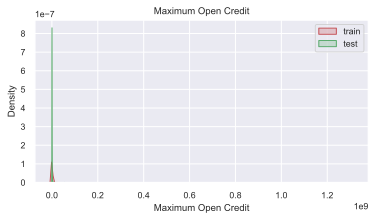

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


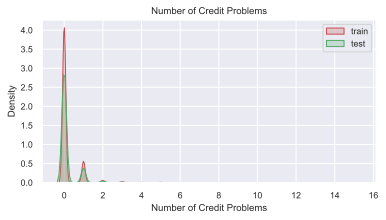

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


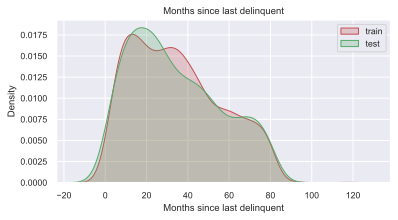

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


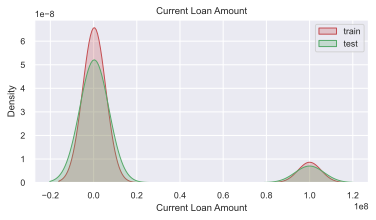

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


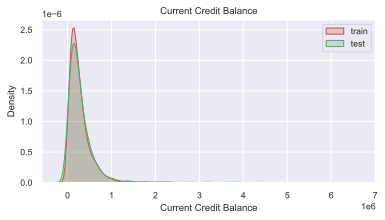

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


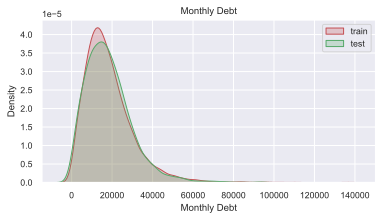

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


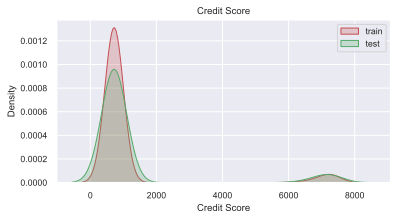

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


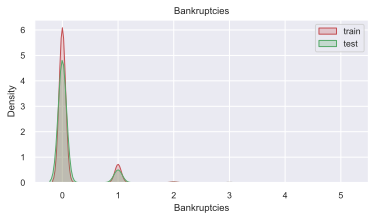

In [61]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

**Обзор номинативных признаков**

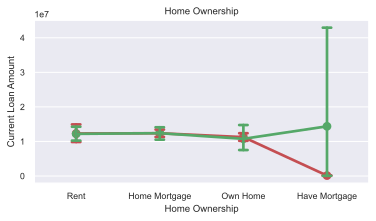

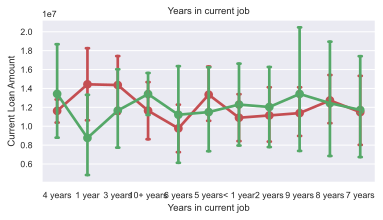

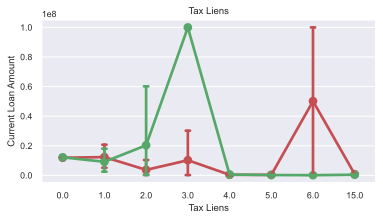

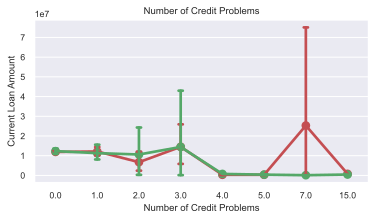

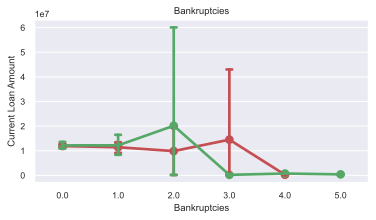

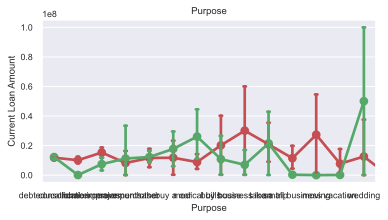

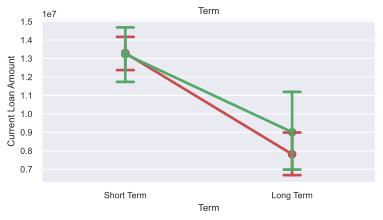

In [59]:
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y='Current Loan Amount', data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y='Current Loan Amount', data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()
    
# 'Credit Score'

Данные в train и test похожи, есть признаки, в которых можно сократить количество категорий, Purpose, Years in Current Job

In [ ]:
# посмотреть похожесть признаков 'Number of Credit Problems', 'Bankruptcies'

In [447]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [448]:
df_train['Years in current job'].isnull().sum()

371

Посмотрим на признак 'Years in current job' в разрезе целевой переменной

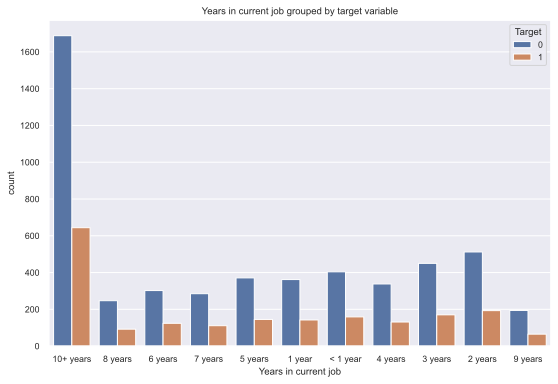

In [64]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Years in current job', hue='Credit Default', data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [65]:
df_train.groupby('Years in current job')['Credit Default'].mean().sort_values()

Years in current job
9 years      0.250965
8 years      0.271386
2 years      0.273759
3 years      0.274194
10+ years    0.276158
4 years      0.279318
7 years      0.280303
5 years      0.281008
1 year       0.281746
< 1 year     0.282416
6 years      0.291080
Name: Credit Default, dtype: float64

**Наблюдение**

Изучив получившийся график и распределение частот, видно, что значения 2 years, 3 years имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 2 years и 3 years признака `Years in current job` в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Рассчитаем наблюдаемые частоты*

In [70]:
df_train['Id'] = df_train.index
years_and_target = df_train.loc[df_train['Years in current job'].isin(['2 years', '3 years']), ['Id', 'Years in current job', 'Credit Default']]
table = years_and_target.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Years in current job,,
2 years,512,193
3 years,450,170


*Проверим нашу гипотезу, используя критерий Хи-квадрат Пирсона*

In [69]:
chi2, p, _, _ = chi2_contingency(table)
p

0.9953464771488197

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории 2 и 3 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

### я пробовала сокращать категории в этом признаке - работало хуже, может можно еще раз сократить не так глобально, как я делала

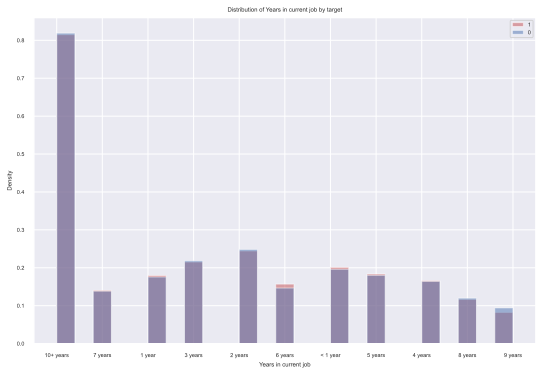

In [449]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1), 
             'Years in current job'].hist(bins=25, color ='r', density=True, alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0), 
             'Years in current job'].hist(bins=25, color ='b', density=True, alpha=0.5, label ='0')
plt.xlabel('Years in current job')
plt.ylabel('Density')
plt.title('Distribution of Years in current job by target')
plt.legend()
plt.show()

* `Home ownership` - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode()
* `Years in current job` - выбросов нет, больше всего значений 10+, можно сократить количество категорий по частоте проявления в целевой переменной
* `Purpose` - много категорий, сократим их количество по частоте проявления
* `Term` - здесь значения нормально распределены, выбросов нет

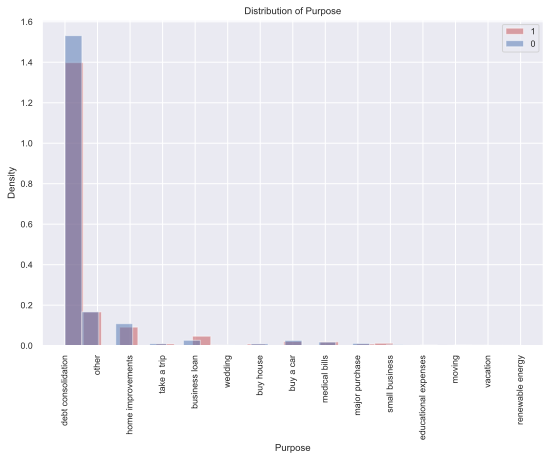

In [63]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1), 
             'Purpose'].hist(bins=25, xrot=90, color ='r', density=True, alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0), 
             'Purpose'].hist(bins=25, color ='b', density=True, alpha=0.5, label ='0')
plt.xlabel('Purpose')
plt.ylabel('Density')
plt.title('Distribution of Purpose')
plt.legend()
plt.show()

In [73]:
df_train.groupby('Purpose')['Credit Default'].mean().sort_values()

Purpose
educational expenses    0.100000
moving                  0.181818
major purchase          0.225000
buy a car               0.250000
vacation                0.250000
home improvements       0.262136
buy house               0.264706
wedding                 0.266667
take a trip             0.270270
debt consolidation      0.278264
other                   0.296241
medical bills           0.309859
business loan           0.426357
small business          0.538462
renewable energy        1.000000
Name: Credit Default, dtype: float64

*Проверим гипотезу о согласованности частот в Purpose, используя критерий Хи-квадрат Пирсона*

In [76]:
business =  df_train['Purpose'].isin(['business loan', 'small business'])
medical = df_train['Purpose'].isin(['medical bills', 'other'])
personal = df_train['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',
                                     'buy house', 'home improvements', 'buy a car', 'vacation'])
other = df_train['Purpose'].isin(['educational expenses', 'moving', 'major purchase']) 

In [77]:
purpose_business_and_target = df_train.loc[business, ['Id', 'Purpose', 'Credit Default']]
purpose_medical_and_target = df_train.loc[medical, ['Id', 'Purpose', 'Credit Default']]
purpose_personal_and_target = df_train.loc[personal, ['Id', 'Purpose', 'Credit Default']]
purpose_other_and_target = df_train.loc[other, ['Id', 'Purpose', 'Credit Default']]
table1 = purpose_business_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table2 = purpose_medical_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table3 = purpose_personal_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table4 = purpose_other_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')

In [81]:
chi2, p, _, _ = chi2_contingency(table1)
p

0.40483403834216214

In [82]:
chi2, p, _, _ = chi2_contingency(table2)
p

0.918726076937743

In [83]:
chi2, p, _, _ = chi2_contingency(table3)
p

0.988484448596236

In [84]:
chi2, p, _, _ = chi2_contingency(table4)
p

0.6670131614664776

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что мы можем объединить категории соответствующим образом.

### Обработка выбросов

* `Home Ownership`

Тип `Have Mortage` скорее всего то же самое, что и `Home Mortage`, объединим их

In [450]:
df_train['Home Ownership'].loc[df_train['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'
df_test['Home Ownership'].loc[df_test['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'

* `Purpose` - много категорий, можно сгруппировать их так, чтобы частота появления целевого события была примерно одинаковая.

* business - business loan, small business, renewable energy
* medical -  medical bills, other
* personal - take a trip, debt consolidation, wedding,  buy house, home improvements, buy a car,  vacation
* other - educational expenses, moving, major purchase 

In [451]:
df_train.groupby('Purpose')['Credit Default'].mean().sort_values()

Purpose
educational expenses    0.100000
moving                  0.181818
major purchase          0.225000
buy a car               0.250000
vacation                0.250000
home improvements       0.262136
buy house               0.264706
wedding                 0.266667
take a trip             0.270270
debt consolidation      0.278264
other                   0.296241
medical bills           0.309859
business loan           0.426357
small business          0.538462
renewable energy        1.000000
Name: Credit Default, dtype: float64

In [452]:
df_train.loc[df_train['Purpose'].isin(['business loan', 'small business', 'renewable energy']), 'Purpose'] = 'business'
df_train.loc[df_train['Purpose'].isin(['medical bills', 'other']), 'Purpose'] = 'medical'
df_train.loc[df_train['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation']), 'Purpose'] = 'personal'
df_train.loc[df_train['Purpose'].isin(['educational expenses', 'moving', 'major purchase']), 'Purpose'] = 'other'

In [453]:
df_test.loc[df_test['Purpose'].isin(['business loan', 'small business', 'renewable energy']), 'Purpose'] = 'business'
df_test.loc[df_test['Purpose'].isin(['medical bills', 'other']), 'Purpose'] = 'medical'
df_test.loc[df_test['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation']), 'Purpose'] = 'personal'
df_test.loc[df_test['Purpose'].isin(['educational expenses', 'moving', 'major purchase']), 'Purpose'] = 'other'

In [454]:
df_train.groupby('Purpose')['Credit Default'].mean().sort_values()

Purpose
other       0.196721
personal    0.276658
medical     0.297554
business    0.452229
Name: Credit Default, dtype: float64

* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности. Они должны быть не меньше текущего долга

In [455]:
df_train[df_train['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,personal,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,personal,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,personal,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,other,Long Term,338096.0,0.0,395.0,659.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,personal,Long Term,672078.0,19.0,8860.0,NaN,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,personal,Long Term,760452.0,0.0,36778.0,725.0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,business,Long Term,751454.0,0.0,15348.0,737.0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,personal,Short Term,134024.0,0.0,0.0,NaN,0


In [456]:
for i in range(0, len(df_train['Maximum Open Credit'].values)):
    if df_train['Maximum Open Credit'].values[i] == 0:
        df_train['Maximum Open Credit'].values[i] = df_train['Current Loan Amount'].values[i]

In [457]:
for i in range(0, len(df_test['Maximum Open Credit'].values)):
    if df_test['Maximum Open Credit'].values[i] == 0:
        df_test['Maximum Open Credit'].values[i] = df_test['Current Loan Amount'].values[i]

* `Current Loan Amount` - есть значения, равные 99999999.0, их 1167. Заменим на медиану


In [458]:
median = df_train['Current Loan Amount'].median()

df_train['Current Loan Amount'].loc[df_train['Current Loan Amount'] == 99999999.0] = median
df_test['Current Loan Amount'].loc[df_test['Current Loan Amount'] == 99999999.0] = median

* `Credit Score` - Выбросы больше 1000. Большинство значений являются событием 1 целевой переменной, то есть целевое событие, и их доля довольно большая (400 наблюдений, против 1184 в другом интервале), заменим их на 550 (минимальный балл), нулевые события - заменим на 750

In [459]:
df_train['Credit Score'].min()

585.0

Добавим дополнительный признак слишком большого значения Credit Score

In [460]:
df_train['Is Credit Score too large'] = 0
df_train['Is Credit Score too large'].loc[df_train['Credit Score'] > 1000] = 1

df_test['Is Credit Score too large'] = 0
df_test['Is Credit Score too large'].loc[df_test['Credit Score'] > 1000] = 1

In [461]:
df_train['Credit Score'].loc[(df_train['Credit Score'] > 750) & (df_train['Credit Default'] == 1) ] = 550
df_train['Credit Score'].loc[(df_train['Credit Score'] > 750) & (df_train['Credit Default'] == 0) ] = 750

In [462]:
# df_test['Credit Score'].value_counts()
df_test['Credit Score'].loc[df_test['Credit Score'] > 750] = 550

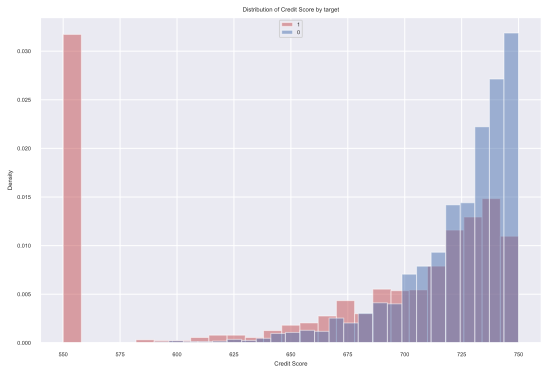

In [463]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

### Обработка пропусков 

* `Years in current job` - Заменим на самое популярное значение

In [464]:
mode = df_train['Years in current job'].mode()[0]
df_train['Years in current job'].loc[df_train['Years in current job'].isnull()] = mode
df_test['Years in current job'].loc[df_test['Years in current job'].isnull()] = mode

* `Months since last delinquent` - скорее всего это отсутствие просрочек, то есть 0, заменим Nan на 0

In [465]:
df_train['Months since last delinquent'].fillna(0, inplace=True)
df_test['Months since last delinquent'].fillna(0, inplace=True)

* `Bankruptcies` - скорее всего пропуски это тоже нули, это самое популярное значение 

In [466]:
df_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

### Обработка категориальных признаков

In [467]:
df_train['Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [468]:
df_train.groupby('Term')['Credit Default'].mean()

Term
0    0.419753
1    0.233441
Name: Credit Default, dtype: float64

In [469]:
df_train['Years in current job'] = df_train['Years in current job'].map({'< 1 year':'0', 
                                                             '1 year':'1', 
                                                             '2 years':'2', 
                                                             '3 years':'3', 
                                                             '4 years':'4', 
                                                             '5 years': '5', 
                                                             '6 years': '6', 
                                                             '7 years': '7', 
                                                             '8 years':'8', 
                                                             '9 years': '9', 
                                                             '10+ years': '10'}).astype(int)
df_test['Years in current job'] = df_test['Years in current job'].map({'< 1 year':'0', 
                                                             '1 year':'1', 
                                                             '2 years':'2', 
                                                             '3 years':'3', 
                                                             '4 years':'4', 
                                                             '5 years': '5', 
                                                             '6 years': '6', 
                                                             '7 years': '7', 
                                                             '8 years':'8', 
                                                             '9 years': '9', 
                                                             '10+ years': '10'}).astype(int)

In [470]:
for cat_colname in df_train.select_dtypes(include='object'):
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
for cat_colname in df_test.select_dtypes(include='object'):
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [471]:
df_train.groupby('Years in current job')['Annual Income'].mean()

Years in current job
0     1.204723e+06
1     1.268811e+06
2     1.324517e+06
3     1.396487e+06
4     1.371733e+06
5     1.330786e+06
6     1.311730e+06
7     1.341805e+06
8     1.390800e+06
9     1.444429e+06
10    1.429994e+06
Name: Annual Income, dtype: float64

### Заполнение нулей для Credit Score и Annual income

* `Annual income` - построим предсказательную модель для заполнения нулей 

In [472]:
#  добавим биннарный признак для пропущенных значений
df_train['Nan Annual Income'] = 0
df_train['Nan Annual Income'].loc[df_train['Annual Income'].isnull()] = 1

df_test['Nan Annual Income'] = 0
df_test['Nan Annual Income'].loc[df_test['Annual Income'].isnull()] = 1

In [473]:
# добавим новый признак средней зарплаты в зависимости от стажа
gp = df_train.groupby(['Years in current job'])['Annual Income'].mean()
df_train['Mean Income By Stage'] = df_train['Years in current job'].map(gp.to_dict())
df_test['Mean Income By Stage'] = df_test['Years in current job'].map(gp.to_dict())

In [474]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Is Credit Score too large',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_medical',
 'Purpose_other',
 'Purpose_personal',
 'Nan Annual Income',
 'Mean Income By Stage']

In [475]:
target_AI = 'Annual Income'
features_AI = ['Mean Income By Stage', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
               'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Term', 
               'Current Loan Amount', 'Monthly Debt', 'Home Ownership_Home Mortgage',
               'Home Ownership_Own Home', 'Home Ownership_Rent']

X_train_AI = df_train[features_AI].loc[df_train['Annual Income'].notnull()]
y_train_AI = df_train[target_AI].loc[df_train['Annual Income'].notnull()]
X_test_AI = df_train[features_AI].loc[df_train['Annual Income'].isnull()]
X_test_AI2 = df_test[features_AI].loc[df_test['Annual Income'].isnull()]

#X_train, X_test, y_train, y_test = train_test_split(X_train_AI, y_train_AI, shuffle=True, test_size=0.3, random_state=21)

In [476]:
catb_for_AI = CatBoostRegressor(eval_metric='R2', 
                                n_estimators=300,
                                max_depth=3,
                                learning_rate=0.03,
                                silent=True,
                                random_state=21)

# catb_for_AI.fit(X_train, y_train)
# y_train_pred = catb_for_AI.predict(X_train)
# y_test_pred = catb_for_AI.predict(X_test)

# evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

catb_for_AI.fit(X_train_AI, y_train_AI)
# Y_test_AI = catb_for_AI.predict(X_test_AI)

In [477]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI.predict(X_test_AI)
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI.predict(X_test_AI2) 

In [478]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [479]:
# %%time
# params = {'learning_rate' : [0.03, 0.02, 0.025, 0.015],
#           'max_depth' : [3, 4, 5, 6],
#           'n_estimators' : [150, 200, 250, 300]}

# GridSearch = GridSearchCV(catb_for_AI, params, scoring='r2', 
#                           cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

* `Credit Score` 

Добавим биннарный признак для пропущенных значений

In [480]:
df_train['Nan Credit Score'] = 0
df_train['Nan Credit Score'].loc[df_train['Credit Score'].isnull()] = 1

df_test['Nan Credit Score'] = 0
df_test['Nan Credit Score'].loc[df_test['Credit Score'].isnull()] = 1

Для пропущенных значений с известным значением Credit Default : заменим на 550, если целевая переменная 1, на 750, если целевая переменная 1

In [483]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Is Credit Score too large',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_medical',
 'Purpose_other',
 'Purpose_personal',
 'Nan Annual Income',
 'Mean Income By Stage',
 'Nan Credit Score']

In [484]:
target_CS = 'Credit Score'
features_CS = ['Annual Income', 'Years in current job', 
               'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
#                'Number of Credit Problems', 'Bankruptcies', 
               'Months since last delinquent',
               'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
               'Mean Income By Stage', 'Is Credit Score too large']

X_train_CS = df_train[features_CS].loc[df_train['Credit Score'].notnull()]
y_train_CS = df_train[target_CS].loc[df_train['Credit Score'].notnull()]
X_test_CS = df_train[features_CS].loc[df_train['Credit Score'].isnull()]
X_test_CS2 = df_test[features_CS].loc[df_test['Credit Score'].isnull()]

# X_train, X_test, y_train, y_test = train_test_split(X_train_CS, y_train_CS, shuffle=True, test_size=0.3, random_state=21)

In [485]:
catb_for_CS = CatBoostRegressor(eval_metric='R2', 
                                n_estimators=400,
                                max_depth=5,
                                learning_rate=0.02,
                                silent=True,
                                random_state=21)

# catb_for_CS.fit(X_train, y_train)
# y_train_pred = catb_for_CS.predict(X_train)
# y_test_pred = catb_for_CS.predict(X_test)

# evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

catb_for_CS.fit(X_train_CS, y_train_CS)

In [486]:
# %%time
# params = {'learning_rate' : [0.03, 0.02, 0.025, 0.015],
#           'max_depth' : [3, 4, 5],
#           'n_estimators' : [150, 200, 250, 300, 350]}

# GridSearch = GridSearchCV(catb_for_CS, params, scoring='r2', 
#                           cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

In [487]:
feature_importances = pd.DataFrame(zip(X_train_CS.columns, catb_for_CS.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
11,Is Credit Score too large,84.338476
6,Term,8.293366
4,Maximum Open Credit,2.223212
7,Current Loan Amount,1.369900
8,Current Credit Balance,0.720135
0,Annual Income,0.675653
5,Months since last delinquent,0.604188
3,Years of Credit History,0.511774
9,Monthly Debt,0.482829
2,Number of Open Accounts,0.410444


In [488]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS.predict(X_test_CS)
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS.predict(X_test_CS2) 

In [489]:
# заполнение медианой - хуже работает
# df_train['Credit Score'].loc[df_train['Credit Score'].isnull()] = df_train['Credit Score'].median()
# df_test['Credit Score'].loc[df_test['Credit Score'].isnull()] = df_train['Credit Score'].median()

### Построение новых признаков

In [490]:
#train
df_train['Class Credit Score'] = 0
df_train['Class Credit Score'].loc[df_train['Credit Score'] < 600] = 1
df_train['Class Credit Score'].loc[(df_train['Credit Score'] >= 600) & (df_train['Credit Score'] < 650)] = 2
df_train['Class Credit Score'].loc[(df_train['Credit Score'] >= 650) & (df_train['Credit Score'] < 700)] = 3
df_train['Class Credit Score'].loc[(df_train['Credit Score'] >= 700) & (df_train['Credit Score'] < 725)] = 4
df_train['Class Credit Score'].loc[(df_train['Credit Score'] >= 725) & (df_train['Credit Score'] < 750)] = 5
df_train['Class Credit Score'].loc[df_train['Credit Score']  >= 750] = 6

In [491]:
#test
df_test['Class Credit Score'] = 0
df_test['Class Credit Score'].loc[df_test['Credit Score'] < 600] = 1
df_test['Class Credit Score'].loc[(df_test['Credit Score'] >= 600) & (df_test['Credit Score'] < 650)] = 2
df_test['Class Credit Score'].loc[(df_test['Credit Score'] >= 650) & (df_test['Credit Score'] < 700)] = 3
df_test['Class Credit Score'].loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 725)] = 4
df_test['Class Credit Score'].loc[(df_test['Credit Score'] >= 725) & (df_test['Credit Score'] < 750)] = 5
df_test['Class Credit Score'].loc[df_test['Credit Score']  >= 750] = 6

In [492]:
df_train['Mounthly Income'] = df_train['Annual Income'] / 12
df_test['Mounthly Income'] = df_test['Annual Income'] / 12

In [493]:
gp = df_train.groupby(['Years in current job'])['Annual Income'].mean()
df_train["Mean Income By Stage"] = df_train['Years in current job'].map(gp.to_dict())
df_test["Mean Income By Stage"] = df_test['Years in current job'].map(gp.to_dict())

In [494]:
gp = df_train.groupby(['Class Credit Score'])['Credit Score'].mean()
df_train["Mean Credit Score By Stage"] = df_train['Class Credit Score'].map(gp.to_dict())
df_test["Mean Credit Score By Stage"] = df_test['Class Credit Score'].map(gp.to_dict())

In [495]:
gp = df_train.groupby(['Years in current job'])['Annual Income'].mean()
df_train["Mean Annual Income by Class Credit Score"] = df_train['Years in current job'].map(gp.to_dict())
df_test["Mean Annual Income by Class Credit Score"] = df_test['Years in current job'].map(gp.to_dict())

In [496]:
# разница между зп и долгом
df_train['Mounthly Income and Debt Diff '] = df_train['Mounthly Income'] - df_train['Monthly Debt']
df_test['Mounthly Income and Debt Diff '] = df_test['Mounthly Income'] - df_test['Monthly Debt']

### Выделение целевой переменной и групп признаков

In [497]:
# df_test = df.loc[df['Credit Default'].isnull()]
# df_train = df.loc[df['Credit Default'].notnull()]

In [498]:
TARGET = 'Credit Default'

BASE_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History',
                      'Maximum Open Credit', 'Number of Credit Problems',
                      'Months since last delinquent', 'Bankruptcies', 'Term',
                      'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                      'Credit Score']

NEW_FEATURE_NAMES = ['Mean Income By Stage',
                     'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
                     'Home Ownership_Rent', 'Purpose_business', 'Purpose_medical', 
                     'Purpose_other', 'Purpose_personal',
                     'Nan Annual Income', 'Nan Credit Score', 'Class Credit Score',
                     'Mounthly Income', 'Mean Credit Score By Stage',
                     'Mean Annual Income by Class Credit Score',
                     'Mounthly Income and Debt Diff ', 'Is Credit Score too large']

### Разбиение на train и test

In [499]:
X = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = df_train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

### Балансировка целевой переменной

Для модели CatBoost будем использовать встроеную балансировку

In [500]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
# df_balanced[TARGET].value_counts()

In [501]:
# X_train_df = df_balanced.drop(columns=TARGET)
# y_train_df = df_balanced[TARGET]

### Построение и оценка базовых моделей

**CatBoost**

In [511]:
catb = CatBoostClassifier(silent=True, random_state=21, class_weights=[1, balance])
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3795
           1       0.78      0.89      0.83      1455

    accuracy                           0.90      5250
   macro avg       0.87      0.90      0.88      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1592
           1       0.51      0.54      0.52       658

    accuracy                           0.71      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250  342
1                304  354


In [512]:
# %%time
# params = {'learning_rate' : [0.03, 0.02, 0.01, 0.015],
#           'max_depth' : [3, 4, 5, 6, 7],
#           'n_estimators' : [100, 200, 250, 300, 350]}

# GridSearch = GridSearchCV(catb, params, scoring='f1', 
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

CPU times: user 21min 27s, sys: 1min 32s, total: 23min
Wall time: 9min 56s


{'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 250}

In [514]:
# %%time
# RandomizedSearch = RandomizedSearchCV(catb, params, scoring='f1', 
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21))
# RandomizedSearch.fit(X_train, y_train)

# RandomizedSearch.best_params_

CPU times: user 1min 56s, sys: 8.62 s, total: 2min 5s
Wall time: 56.1 s


{'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.03}

In [536]:
catb = CatBoostClassifier(learning_rate=0.03, 
                          max_depth=4,
                          n_estimators=300,
                          class_weights=[1, balance],
                          silent=True,                           
                          random_state=21)

catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3795
           1       0.54      0.69      0.60      1455

    accuracy                           0.75      5250
   macro avg       0.70      0.73      0.71      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1592
           1       0.49      0.62      0.55       658

    accuracy                           0.70      2250
   macro avg       0.66      0.68      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1174  418
1                250  408


In [505]:
f1_score(y_test, y_test_pred, average=None)

array([0.77502478, 0.53767821])

In [506]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
10,Current Loan Amount,29.524089
26,Mean Credit Score By Stage,21.150904
24,Class Credit Score,19.936879
13,Credit Score,10.733235
9,Term,2.701906
28,Mounthly Income and Debt Diff,2.384693
22,Nan Annual Income,1.696013
0,Annual Income,1.277412
25,Mounthly Income,1.275235
23,Nan Credit Score,1.183545


### Перекрестная проверка

In [537]:
cv_score = cross_val_score(
    catb,
    X,
    y,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.5282631 , 0.57317073, 0.53180396, 0.5406547 , 0.52873563])

In [538]:
cv_score.mean(), cv_score.std()

(0.5405256258408849, 0.01691839475959116)

In [539]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.5236072310812938, 0.557444020600476)

### Сделаем предсказания на тестовых данных

In [540]:
y_train_fin = df_train['Credit Default']

X_train_fin = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

X_test_fin = df_test[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

catb.fit(X_train_fin, y_train_fin)

y_test_fin = catb.predict(X_test_fin)

In [541]:
CreditDefault_pred = pd.DataFrame({'Id': np.arange(0,y_test_fin.shape[0]), 'Credit Default': y_test_fin})
CreditDefault_pred.to_csv('Sokolova_predictions.csv', index=False, encoding='utf-8', sep=',')
CreditDefault_pred.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,1
8,8,0
9,9,0


In [542]:
CreditDefault_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Id              2500 non-null   int64
 1   Credit Default  2500 non-null   int64
dtypes: int64(2)
memory usage: 39.2 KB


In [543]:
pickle.dump(
    catb, open("model.pkl", "wb")
)